### 迁移学习的主要场景
* 微调Convnet：使用预训练的网络(如在imagenet 1000上训练而来的网络)来初始化自己的网络，而不是随机初始化。其他的训练步骤不变。
* 将Convnet看成固定的特征提取器:首先固定ConvNet除了最后的全连接层外的其他所有层。最后的全连接层被替换成一个新的随机 初始化的层，只有这个新的层会被训练[只有这层参数会在反向传播时更新

### 1. 导入相关的包

In [1]:
from __future__ import print_function,division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets,models,transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  # 打开交互模式 plt.plot后立即显示图片，不阻塞代码的继续运行

### 2.加载数据
* 目标:训练一个模型来分类ants 和 bees
* 数据集：
    * 各有约120张训练图片
    * 75张验证图片
* 从零开始在 如此小的数据集上进行训练通常是很难泛化的
    * 由于我们使用迁移学习，模型的泛化能力会相当好。

#### 函数使用
* transforms.Resize (256) 是按照比例把图像最小的一个边长放缩到256，另一边按照相同比例放缩
* torchvision.datasets.ImageFolder 要求数据的组织形式为：root/dog/xxx.png
    * __init__(self,root,transform,target_transform,loader)
    * root: 图片存储的根目录，即各类别文件夹所在目录的上一级目录
    * transform：对图片进行预处理的操作（函数），原始图片作为输入，返回一个转换后的图片
    * target_transform：对图片类别进行预处理的操作，输入为 target，输出对其的转换
    * loader：表示数据集加载方式，通常默认加载方式即可


In [2]:
# 训练集数据：扩充和归一化
# 验证集数据：归一化

data_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(224),  #随机裁剪一个area然后再resize
        transforms.RandomHorizontalFlip(),  #随机水平翻转
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val':
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# 数据集所在目录
data_dir = 'data/hymenoptera_data'
# 数据集
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x), 
                                         data_transforms[x])
                  for x in ['train','val']}
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,shuffle = True, num_workers=4)
                for x in ['train','val']}

# 训练集和验证集的数据量
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}

class_names = image_datasets['train'].classes
print('类名: ', class_names)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

类名:  ['ants', 'bees']


### 3.可视化部分数据
* iter(dataloader)访问时，imgs在前，labels在后，分别表示：图像转换0~1之间的值，labels为标签值。并且imgs和labels是按批次进行输入的。
* Pytorch torchvision.utils.make_grid()
    * make_grid的作用是将若干幅图像拼成一幅图像
* next() 返回迭代器的下一个项目,和生成迭代器的 iter() 函数一起使用
* numpy.clip(a, a_min, a_max, out=None)
    * a : 输入的数组
    * a_min: 限定的最小值 也可以是数组 如果为数组时 shape必须和a一样
    * a_max:限定的最大值 也可以是数组 shape和a一样
    * out：剪裁后的数组存入的数组

classes:  tensor([0, 0, 1, 0])


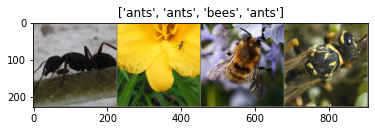

In [3]:
def imshow(inp, title=None):
    # 将图像从张量形式转换为numpy格式
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp,0,1)

    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    
    plt.pause(0.001)

# 获得一批训练数据
images,classes = next(iter(dataloaders['train']))
print('classes: ',classes)

# 批量制作网络
out = torchvision.utils.make_grid(images)

imshow(out,title=[class_names[x] for x in classes])

### 4.训练模型
* 参数scheduler是一个来自 torch.optim.lr_scheduler的学习速率调整类的对象
    * scheduler是对优化器的学习率进行调整,正常情况下训练的步骤越大，学习率应该变得越小
    * 只有用了optimizer.step()，模型才会更新，而scheduler.step()是对lr进行调整
    * 通常我们在scheduler的step_size表示scheduler.step()每调用step_size次，对应的学习率就会按照策略调整一次
    * scheduler.step()是放在mini-batch里面，那么step_size指的是经过这么多次迭代，学习率改变一次
    * torch.optim.lr_scheduler模块提供了一些根据epoch训练次数来调整学习率的方法
        * 一般情况下我们会设置随着epoch的增大而逐渐减小学习率从而达到更好的训练效果
*  time time() 返回当前时间的时间戳
* .to(device)
    * 读取数据时的tensor变量copy一份到device所指定的GPU中，之后的所有运算都在GPU上进行
    * 需要写的次数等于需要保存GPU上的tensor变量的个数
    * 一般情况下这些tensor变量都是最开始读数据时的tensor变量，后面衍生的变量自然也都在GPU上


In [8]:
def train_model(model,criterion,optimizer,scheduler,num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        # 训练到第个epoch上了
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print('-' * 10)

        # 每个epoch都有一个训练和验证阶段
        for phase in ['train','val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else :
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # 迭代数据
            for inputs, labels in dataloaders[phase]:
                # 将需要训练和验证的数据都放到GPU上去
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 将参数梯度置零
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'): # 允许记录参数的梯度或者不允许
                    outputs = model(inputs)
                    _,preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计
                running_loss += loss.item() * inputs.size(0) # batch值
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} loss: {:.4f} acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))
            
            # 更新最优权重的最高准确率
            if phase=='val' and epoch_acc > best_acc:
                best_model_wts = copy.deepcopy(model.state_dict())
                best_acc = epoch_acc

        print()
    
    # 计算花费的时间
    time_elapse = time.time() - since
    print('训练花费的时间为：{:.0f} m  {:.0f}s'.format(time_elapse/60, time_elapse/60))
    # 打印当前的最高成功率
    print('Best Acc: {:4f}'.format(best_acc))

    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model

### 5.可视化模型的预测结果

In [12]:
# 一个通用的展示少量预测图片的函数
def visualize_model(model,num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far =0
    fig = plt.figure()

    #在该模块下，所有计算得出的tensor的requires_grad都自动设置为False。
    with torch.no_grad():
        for i,(inputs,labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _,preds = torch.max(outputs,1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2,2,images_so_far)
                ax.axis('off')
                ax.set_title('predected: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                # print(inputs.cpu().data[j]) 图像的张量数值

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)



### 6.微调ConvNet
* 加载预训练模型并重置最终完全连接的图层

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features # 提取fc层中固定的参数数量
print('特征数量',num_ftrs)
model_ft.fc = nn.Linear(num_ftrs,2)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# 观察所有参数都在正在优化
optimizer_ft = optim.SGD(params=model_ft.parameters(),lr =0.001,momentum =0.9)

# 每7个epoch衰减LR通过设置gamma=0.1

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=0.1)


特征数量 512


### 训练和评估模型

Epoch 0/24
----------
train loss: 0.3190 acc: 0.8525
val loss: 0.1669 acc: 0.9412

Epoch 1/24
----------
train loss: 0.2230 acc: 0.9016
val loss: 0.1965 acc: 0.9281

Epoch 2/24
----------
train loss: 0.2427 acc: 0.8852
val loss: 0.1849 acc: 0.9346

Epoch 3/24
----------
train loss: 0.2618 acc: 0.9180
val loss: 0.1729 acc: 0.9412

Epoch 4/24
----------
train loss: 0.2683 acc: 0.8811
val loss: 0.1775 acc: 0.9346

Epoch 5/24
----------
train loss: 0.2150 acc: 0.9016
val loss: 0.1762 acc: 0.9346

Epoch 6/24
----------
train loss: 0.3064 acc: 0.8607
val loss: 0.1692 acc: 0.9346

Epoch 7/24
----------
train loss: 0.2805 acc: 0.8607
val loss: 0.1721 acc: 0.9281

Epoch 8/24
----------
train loss: 0.3327 acc: 0.8443
val loss: 0.1726 acc: 0.9150

Epoch 9/24
----------
train loss: 0.2925 acc: 0.8893
val loss: 0.1709 acc: 0.9281

Epoch 10/24
----------
train loss: 0.2537 acc: 0.8975
val loss: 0.1803 acc: 0.9216

Epoch 11/24
----------
train loss: 0.2496 acc: 0.8934
val loss: 0.1799 acc: 0.9150

Ep

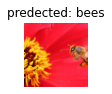

tensor([[[ 2.1975,  2.2318,  2.2318,  ...,  2.1633,  2.1633,  2.1975],
         [ 2.2147,  2.2318,  2.2318,  ...,  2.1633,  2.1633,  2.1633],
         [ 2.2147,  2.2489,  2.2318,  ...,  2.1975,  2.1975,  2.1975],
         ...,
         [ 0.3823,  0.3138,  0.2624,  ...,  2.1633,  2.1462,  2.1975],
         [ 0.5022,  0.4851,  0.4337,  ...,  2.1633,  2.1804,  2.1975],
         [ 0.6734,  0.6563,  0.5878,  ...,  2.1804,  2.1975,  2.1975]],

        [[-1.3880, -1.3529, -1.3529,  ..., -1.1429, -1.1429, -1.1078],
         [-1.3704, -1.3529, -1.3529,  ..., -1.1779, -1.1779, -1.1779],
         [-1.3704, -1.3354, -1.3354,  ..., -1.1954, -1.1954, -1.1954],
         ...,
         [-2.0007, -2.0182, -2.0182,  ..., -1.2304, -1.4405, -1.5280],
         [-2.0007, -2.0007, -2.0182,  ..., -1.2304, -1.3880, -1.4755],
         [-1.9657, -2.0007, -2.0182,  ..., -1.2829, -1.3880, -1.4930]],

        [[-0.6193, -0.5844, -0.5844,  ..., -0.3404, -0.3404, -0.3230],
         [-0.5844, -0.5495, -0.5495,  ..., -0

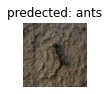

tensor([[[-0.5767, -0.4054, -0.4568,  ..., -1.1418, -0.9192, -0.4054],
         [-0.5424, -0.4226, -0.4054,  ..., -1.1760, -0.8164, -0.4226],
         [-0.4911, -0.3541, -0.3198,  ..., -1.2274, -0.9192, -0.4911],
         ...,
         [-1.0390, -0.6452, -0.3883,  ..., -0.8507, -0.6623, -0.5082],
         [-1.3473, -1.1589, -1.0219,  ..., -1.0048, -0.8678, -0.6109],
         [-1.5185, -1.4158, -1.4500,  ..., -1.1418, -1.1247, -0.7650]],

        [[-0.6176, -0.4776, -0.5651,  ..., -0.9678, -0.8452, -0.4076],
         [-0.5826, -0.4951, -0.4951,  ..., -1.0028, -0.6702, -0.3725],
         [-0.5126, -0.4076, -0.4076,  ..., -1.1604, -0.8452, -0.4426],
         ...,
         [-0.9853, -0.6527, -0.3901,  ..., -0.9153, -0.8102, -0.6352],
         [-1.2829, -1.1429, -1.0203,  ..., -0.9853, -0.9328, -0.6877],
         [-1.4580, -1.3704, -1.3354,  ..., -1.0728, -1.1253, -0.8803]],

        [[-0.6541, -0.6193, -0.7064,  ..., -0.7936, -0.7761, -0.4275],
         [-0.6018, -0.5670, -0.5844,  ..., -0

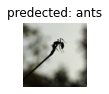

tensor([[[ 0.1426,  0.1768,  0.2624,  ...,  1.3584,  1.3584,  1.4269],
         [ 0.0398,  0.1768,  0.2282,  ...,  1.2899,  1.3242,  1.3584],
         [-0.0116,  0.0741,  0.0569,  ...,  1.2043,  1.2557,  1.2557],
         ...,
         [-1.6213, -1.6898, -1.6384,  ..., -0.9020, -0.8507, -0.7822],
         [-1.6042, -1.6213, -1.6213,  ..., -0.8507, -0.7650, -0.7308],
         [-1.6384, -1.6042, -1.5870,  ..., -0.7822, -0.7137, -0.6452]],

        [[ 0.2577,  0.2927,  0.3978,  ...,  1.5532,  1.5707,  1.5882],
         [ 0.1527,  0.2227,  0.3452,  ...,  1.5007,  1.5182,  1.5532],
         [ 0.0651,  0.1527,  0.2052,  ...,  1.4482,  1.4482,  1.4832],
         ...,
         [-1.5280, -1.5630, -1.4930,  ..., -0.8102, -0.7577, -0.6877],
         [-1.4930, -1.5280, -1.4930,  ..., -0.7227, -0.6702, -0.6527],
         [-1.5455, -1.5280, -1.4930,  ..., -0.6527, -0.6001, -0.5301]],

        [[ 0.1128,  0.2696,  0.3916,  ...,  1.6291,  1.6640,  1.6640],
         [ 0.0779,  0.1476,  0.3219,  ...,  1

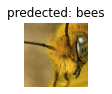

tensor([[[ 0.4508,  0.4508,  0.4679,  ...,  0.4851,  0.5022,  0.5193],
         [ 0.4508,  0.4508,  0.4508,  ...,  0.4508,  0.4508,  0.4679],
         [ 0.4508,  0.4679,  0.4679,  ...,  0.4166,  0.4166,  0.4337],
         ...,
         [ 1.1872,  1.1529,  1.1700,  ...,  1.3584,  1.3755,  1.4098],
         [ 1.1529,  1.1358,  1.1358,  ...,  1.3927,  1.4440,  1.4954],
         [ 1.1700,  1.1700,  1.1529,  ...,  1.4783,  1.5125,  1.5639]],

        [[ 0.1176,  0.1176,  0.1352,  ..., -0.2325, -0.2325, -0.2325],
         [ 0.1176,  0.1176,  0.1176,  ..., -0.2675, -0.2675, -0.2500],
         [ 0.1176,  0.1352,  0.1352,  ..., -0.2850, -0.3025, -0.2850],
         ...,
         [ 0.7829,  0.7479,  0.7654,  ...,  0.8354,  0.8704,  0.9055],
         [ 0.7479,  0.7304,  0.7304,  ...,  0.8880,  0.9405,  0.9755],
         [ 0.7654,  0.7654,  0.7479,  ...,  0.9580,  1.0105,  1.0455]],

        [[-0.4798, -0.4798, -0.4624,  ..., -1.3687, -1.3861, -1.3687],
         [-0.4798, -0.4798, -0.4798,  ..., -1

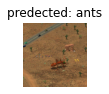

tensor([[[-0.0972,  0.3652,  0.2453,  ..., -0.3883, -1.2274, -0.4397],
         [ 0.2796,  0.4337,  0.3481,  ..., -0.8335, -1.0562,  0.1597],
         [ 0.1939,  0.2796,  0.2111,  ..., -1.1247, -0.4054,  0.3309],
         ...,
         [ 0.1083,  0.5707,  0.3138,  ...,  0.6734,  0.9474,  0.9303],
         [ 0.0912,  0.3994,  0.3994,  ...,  0.4337,  0.8789,  1.1529],
         [-0.2342, -0.0801,  0.1426,  ...,  0.2111,  0.7077,  1.1358]],

        [[-0.4951, -0.1450, -0.3025,  ..., -0.3550, -1.0028, -0.5651],
         [-0.2850, -0.1625, -0.2500,  ..., -0.4951, -0.8452, -0.1625],
         [-0.5301, -0.4076, -0.4601,  ..., -0.9328, -0.4426, -0.1625],
         ...,
         [-0.3901, -0.1625, -0.3200,  ..., -0.0924,  0.1001,  0.1001],
         [-0.2675, -0.2150, -0.2675,  ..., -0.2850,  0.0651,  0.2927],
         [-0.6176, -0.6877, -0.6001,  ..., -0.4426, -0.0224,  0.3627]],

        [[-0.7761, -0.5844, -0.7587,  ..., -0.7936, -1.4210, -0.9504],
         [-0.6541, -0.6018, -0.6890,  ..., -0

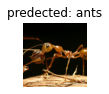

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1008],
         [-2.1008, -2.1008, -2.0837,  ..., -2.1008, -2.1008, -2.1008],
         [-2.1008, -2.1008, -2.1179,  ..., -2.0837, -2.0837, -2.1008],
         ...,
         [ 1.6324,  1.5810,  1.5639,  ...,  2.0948,  2.0948,  2.1633],
         [ 1.5125,  1.4440,  1.3755,  ...,  2.0263,  1.8208,  1.4612],
         [ 1.4269,  1.4098,  1.3927,  ...,  1.6667,  1.5982,  1.3584]],

        [[-2.0007, -2.0007, -2.0007,  ..., -1.9657, -2.0007, -1.9832],
         [-2.0007, -1.9832, -1.9657,  ..., -1.9832, -2.0007, -2.0007],
         [-2.0182, -2.0007, -2.0007,  ..., -1.9832, -2.0007, -2.0182],
         ...,
         [ 0.9580,  0.8529,  0.7129,  ...,  1.2731,  1.5707,  1.6057],
         [ 0.8004,  0.7479,  0.6078,  ...,  1.1856,  0.8704,  0.6254],
         [ 0.8004,  0.7654,  0.7829,  ...,  0.6604,  0.4853,  0.3978]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.7870],
         [-1.8044, -1.7870, -1.7870,  ..., -1

In [10]:
model_ft = train_model(model_ft,criterion,optimizer_ft,exp_lr_scheduler,num_epochs=25)
visualize_model(model_ft)

### 7.ConvNet作为固定特征提取器
* 需要冻结除最后一层之外的所有网络。
* 通过设置requires_grad == Falsebackward()来冻结参数，这样在反向传播backward()的时候他们的梯度就不会被计算

In [13]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs,2)
model_conv = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(),lr=0.001,momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv,7,0.1)


Epoch 0/24
----------


D:\Anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train loss: 0.3143 acc: 0.8566
val loss: 0.2807 acc: 0.8889

Epoch 1/24
----------
train loss: 0.3831 acc: 0.8689
val loss: 0.1762 acc: 0.9346

Epoch 2/24
----------
train loss: 0.2382 acc: 0.9057
val loss: 0.1760 acc: 0.9346

Epoch 3/24
----------
train loss: 0.3434 acc: 0.8402
val loss: 0.2126 acc: 0.9346

Epoch 4/24
----------
train loss: 0.6413 acc: 0.7623
val loss: 0.5545 acc: 0.7974

Epoch 5/24
----------
train loss: 0.3594 acc: 0.8770
val loss: 0.1889 acc: 0.9346

Epoch 6/24
----------
train loss: 0.3297 acc: 0.8648
val loss: 0.1779 acc: 0.9412

Epoch 7/24
----------
train loss: 0.3433 acc: 0.8770
val loss: 0.1714 acc: 0.9412

Epoch 8/24
----------
train loss: 0.3531 acc: 0.8484
val loss: 0.2045 acc: 0.9281

Epoch 9/24
----------
train loss: 0.2654 acc: 0.9180
val loss: 0.1680 acc: 0.9412

Epoch 10/24
----------
train loss: 0.3190 acc: 0.8893
val loss: 0.1948 acc: 0.9346

Epoch 11/24
----------
train loss: 0.3123 acc: 0.8730
val loss: 0.2017 acc: 0.9346

Epoch 12/24
----------
t

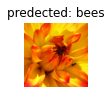

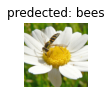

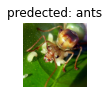

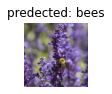

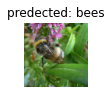

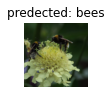

In [14]:
model_conv = train_model(model_conv,criterion,optimizer_conv,exp_lr_scheduler,25)
visualize_model(model_conv)
plt.ioff()
plt.show()